In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import requests
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) #plotly
from sklearn.manifold import trustworthiness

In [11]:
!pip install -U kaleido

Defaulting to user installation because normal site-packages is not writeable


In [12]:
#github source: https://github.com/hyhuang00/scRNA-DR2020/blob/main/experiments/run_eval.py
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics.pairwise import euclidean_distances
import scipy.stats
from scipy.spatial.kdtree import distance_matrix
from sklearn.model_selection import cross_val_score

def knn_eval(X, y):
    knn_cv = KNeighborsClassifier()
    cv_scores = cross_val_score(knn_cv, X, y, cv=5)
    #print each cv score (accuracy) and average them
    cv_scores_mean = np.mean(cv_scores)
    #print(cv_scores)
    #print(‘cv_scores mean:{}’.format(np.mean(cv_scores)))
    return cv_scores_mean


def spearman_correlation_eval(X, X_new, n_points=1000, random_seed=100):
    '''Evaluate the global structure of an embedding via spearman correlation in
    distance matrix, following https://www.nature.com/articles/s41467-019-13056-x
    '''
    # Fix the random seed to ensure reproducability
    rng = np.random.default_rng(seed=random_seed)
    dataset_size = X.shape[0]

    # Sample n_points points from the dataset randomly
    sample_index = rng.choice(np.arange(dataset_size), size=n_points, replace=False)

    # Generate the distance matrix in high dim and low dim
    dist_high = distance_matrix(X[sample_index], X[sample_index])
    dist_low = distance_matrix(X_new[sample_index], X_new[sample_index])
    dist_high = dist_high.reshape([-1])
    dist_low = dist_low.reshape([-1])

    # Calculate the correlation
    corr, pval = scipy.stats.spearmanr(dist_high, dist_low)
    return dist_high, dist_low, corr, pval

In [13]:
import plotly.express as px

## Visualization and Evaluation of 1000 Genomes Project 

### PCA - 1000 Genomes

In [7]:
pca_1000gens = pd.read_csv("PCA_GPU_1000genomes.csv").set_index("Unnamed: 0")
pca_1000gens.head()

component1  component2 Superpopulation name
Unnamed: 0                                             
HG00096      -1.552997    1.867352    European Ancestry
HG00097      -1.730807    1.883513    European Ancestry
HG00099      -1.972736    2.060777    European Ancestry
HG00100      -2.437779    2.292182    European Ancestry
HG00101      -2.180666    2.179227    European Ancestry

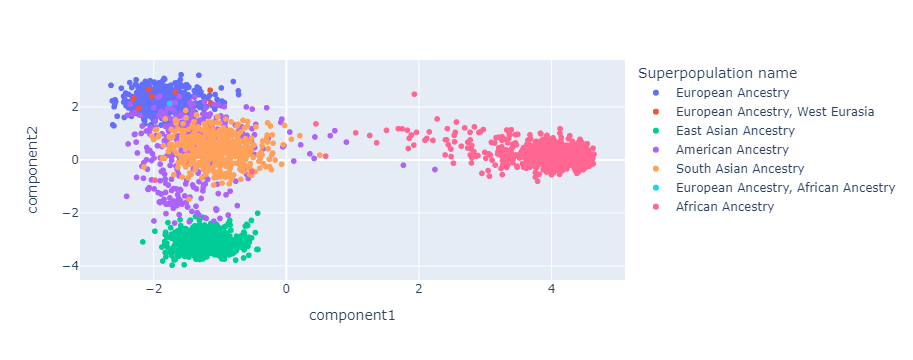

In [8]:
fig = px.scatter(pca_1000gens, x="component1", y="component2", color="Superpopulation name")
fig.show()

In [9]:
from sklearn.preprocessing import OneHotEncoder as CPU_ohe
from sklearn.decomposition import PCA
df_genetic_data = pd.read_hdf(path_or_buf="1000_genomes_project.h5", key="Genotypes_variants_per_sample")
array = CPU_ohe().fit_transform(df_genetic_data).toarray().astype(np.float64)  
expl_var_ratio = PCA(n_components=2).fit(array).explained_variance_ratio_
print(f"variance explained by first component: {expl_var_ratio[0]}")
print(f"variance explained by second component: {expl_var_ratio[1]}")
print(f"Whole variance with 2 components: {expl_var_ratio.sum()}")

variance explained by first component: 0.2095285197824582
variance explained by second component: 0.12286154131104203
Whole variance with 2 components: 0.3323900610935002


In [10]:
#df.drop(column_name, axis=1)
X = pca_1000gens.drop("Superpopulation name",  axis=1)
y = pca_1000gens["Superpopulation name"]
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
avg_acc = knn_eval(X=X, y=y)
avg_acc

0.8793892215568861

In [11]:
dist_high, dist_low, corr, pval = spearman_correlation_eval(X=array, X_new=X.to_numpy())
#corr = scipy.stats.spearmanr(array, X)
print(f"Spearman correlation between pairwise distances: {corr}")

Spearman correlation between pairwise distances: 0.8689606018273054


In [12]:
fig.write_image("pca_1000genomes.png")

### T-SNE default

In [13]:
tsne_1000gens = pd.read_csv("TSNE_GPU_1000genomes.csv").set_index("Unnamed: 0")
tsne_1000gens.head()

component1  component2 Superpopulation name
Unnamed: 0                                             
HG00096     -19.458225   33.937195    European Ancestry
HG00097       2.362793   61.716125    European Ancestry
HG00099      13.721524   47.530950    European Ancestry
HG00100     -12.949867   60.266125    European Ancestry
HG00101     -24.531895   33.519676    European Ancestry

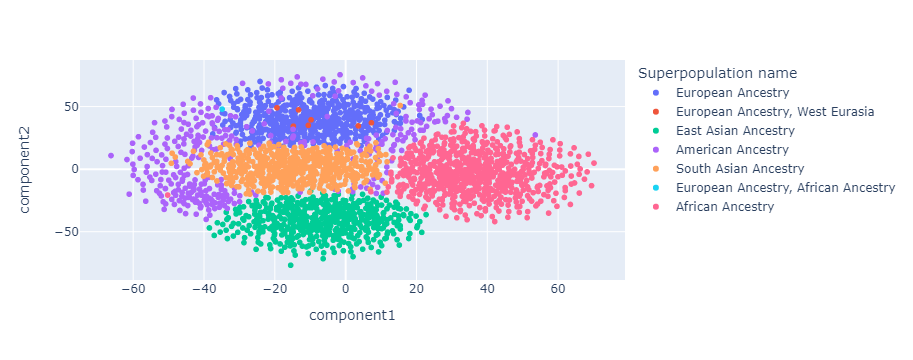

In [14]:
fig = px.scatter(tsne_1000gens, x="component1", y="component2", color="Superpopulation name")
fig.show()

In [15]:
X = tsne_1000gens.drop("Superpopulation name",  axis=1)
y = tsne_1000gens["Superpopulation name"]
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
avg_acc = knn_eval(X=X, y=y)
avg_acc

0.92492375249501

In [16]:
dist_high, dist_low, corr, pval = spearman_correlation_eval(X=array, X_new=X.to_numpy())
#corr = scipy.stats.spearmanr(array, X)
print(f"Spearman correlation between pairwise distances: {corr}")

Spearman correlation between pairwise distances: 0.6991559455115908


In [17]:
trust = trustworthiness(array, X)
trust

0.9033838806627345

In [18]:
fig.write_image("tsne_1000genomes_default.png")

### t-SNE perplexity 10

In [19]:
tsne_1000gens = pd.read_csv("TSNE_1000genomes_perp10.csv").set_index("Unnamed: 0")
tsne_1000gens.head()

component1  component2 Superpopulation name
Unnamed: 0                                             
HG00096      10.209116  -75.384980    European Ancestry
HG00097      38.894085  -54.368877    European Ancestry
HG00099      14.978940  -65.575100    European Ancestry
HG00100      46.976425  -30.126760    European Ancestry
HG00101      43.883450  -28.811320    European Ancestry

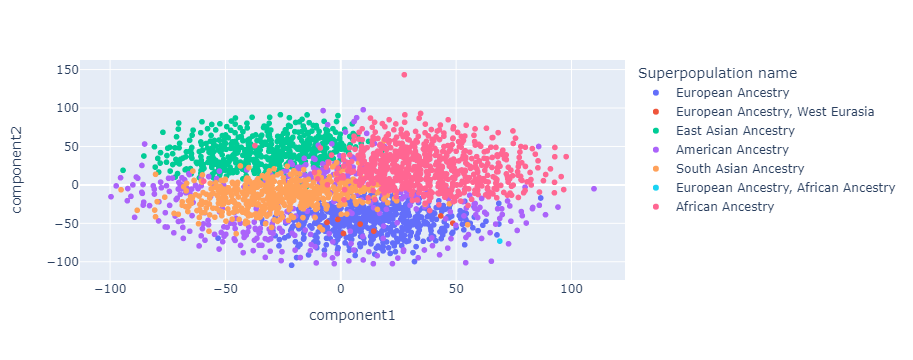

In [20]:
fig = px.scatter(tsne_1000gens, x="component1", y="component2", color="Superpopulation name")
fig.show()

In [21]:
X = tsne_1000gens.drop("Superpopulation name",  axis=1)
y = tsne_1000gens["Superpopulation name"]
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
avg_acc = knn_eval(X=X, y=y)
avg_acc

0.8059089820359283

In [22]:
dist_high, dist_low, corr, pval = spearman_correlation_eval(X=array, X_new=X.to_numpy())
#corr = scipy.stats.spearmanr(array, X)
print(f"Spearman correlation between pairwise distances: {corr}")

Spearman correlation between pairwise distances: 0.533621715928919


In [23]:
trust = trustworthiness(array, X)
trust

0.8084112535328091

In [24]:
fig.write_image("tsne_1000genomes_perp10.png")

### t-SNE with perplexity 50

In [25]:
tsne_1000gens = pd.read_csv("TSNE_1000genomes_perp50.csv").set_index("Unnamed: 0")
tsne_1000gens.head()

component1  component2 Superpopulation name
Unnamed: 0                                             
HG00096      23.033419   32.635400    European Ancestry
HG00097       8.279771   45.255360    European Ancestry
HG00099       4.693389   51.592350    European Ancestry
HG00100       8.327029   49.280888    European Ancestry
HG00101      12.755760   28.303286    European Ancestry

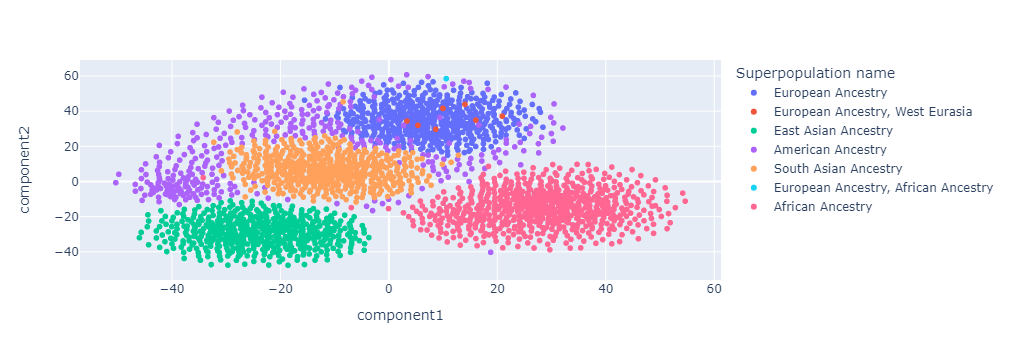

In [26]:
fig = px.scatter(tsne_1000gens, x="component1", y="component2", color="Superpopulation name")
fig.show()

In [27]:
X = tsne_1000gens.drop("Superpopulation name",  axis=1)
y = tsne_1000gens["Superpopulation name"]
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
avg_acc = knn_eval(X=X, y=y)
avg_acc

0.9484862275449102

In [28]:
dist_high, dist_low, corr, pval = spearman_correlation_eval(X=array, X_new=X.to_numpy())
#corr = scipy.stats.spearmanr(array, X)
print(f"Spearman correlation between pairwise distances: {corr}")

Spearman correlation between pairwise distances: 0.7424916378680104


In [29]:
trust = trustworthiness(array, X)
trust

0.934755992975342

In [30]:
fig.write_image("tsne_1000genomes_perp50.png")

### UMAP default

In [5]:
umap_1000gens = pd.read_csv("UMAP_GPU_1000genomes.csv").set_index("Unnamed: 0")
umap_1000gens.head()

component1  component2 Superpopulation name
Unnamed: 0                                             
HG00096      -0.315826    6.784998    European Ancestry
HG00097       0.126371    7.973272    European Ancestry
HG00099       0.411083    7.316635    European Ancestry
HG00100      -0.461454    8.295925    European Ancestry
HG00101      -0.857195    6.983219    European Ancestry

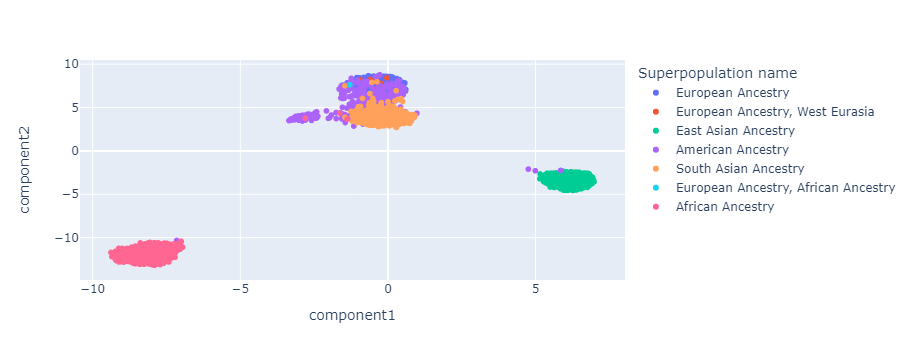

In [6]:
fig = px.scatter(umap_1000gens, x="component1", y="component2", color="Superpopulation name")
fig.show()

In [9]:
from sklearn.preprocessing import OneHotEncoder as CPU_ohe
X = umap_1000gens.drop("Superpopulation name",  axis=1)
y = umap_1000gens["Superpopulation name"]
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
df_genetic_data = pd.read_hdf(path_or_buf="1000_genomes_project.h5", key="Genotypes_variants_per_sample")
array = CPU_ohe().fit_transform(df_genetic_data).toarray().astype(np.float64) 
avg_acc = knn_eval(X=X, y=y)
dist_high, dist_low, corr, pval = spearman_correlation_eval(X=array, X_new=X.to_numpy())
trust = trustworthiness(array, X)
print(avg_acc)
print(trust)
print(f"Spearman correlation between pairwise distances: {corr}")
fig.write_image("umap_1000genomes_default.png")

0.9109381237524949
0.8894509169943475
Spearman correlation between pairwise distances: 0.8019682323209659


### Umap neighbors 5

In [34]:
umap_1000gens = pd.read_csv("UMAP_1000genomes_neighbors5.csv").set_index("Unnamed: 0")
umap_1000gens.head()

component1  component2 Superpopulation name
Unnamed: 0                                             
HG00096      -6.699903    1.198996    European Ancestry
HG00097      -7.847446    0.109173    European Ancestry
HG00099      -5.703587    0.462115    European Ancestry
HG00100      -6.405853   -0.387904    European Ancestry
HG00101      -6.847098    1.048467    European Ancestry

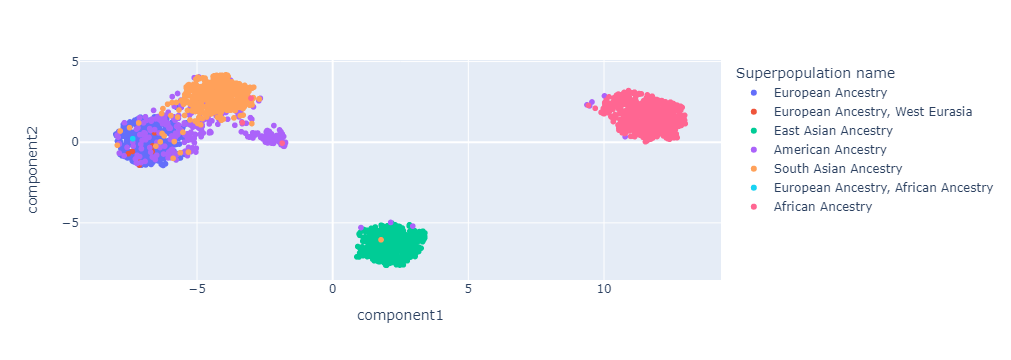

In [35]:
fig = px.scatter(umap_1000gens, x="component1", y="component2", color="Superpopulation name")
fig.show()

In [36]:
X = umap_1000gens.drop("Superpopulation name",  axis=1)
y = umap_1000gens["Superpopulation name"]
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
avg_acc = knn_eval(X=X, y=y)
dist_high, dist_low, corr, pval = spearman_correlation_eval(X=array, X_new=X.to_numpy())
trust = trustworthiness(array, X)
print(avg_acc)
print(trust)
print(f"Spearman correlation between pairwise distances: {corr}")
fig.write_image("umap_1000genomes_neighbor5.png")

0.8985588822355289
0.8917178347976571
Spearman correlation between pairwise distances: 0.7644079428021773


### UMAP 50 neighbours

In [37]:
umap_1000gens = pd.read_csv("UMAP_1000genomes_neighbors50.csv").set_index("Unnamed: 0")
umap_1000gens.head()

component1  component2 Superpopulation name
Unnamed: 0                                             
HG00096       2.924818   -9.766457    European Ancestry
HG00097       3.506863  -10.447679    European Ancestry
HG00099       3.287875   -9.561160    European Ancestry
HG00100       4.168390  -10.273666    European Ancestry
HG00101       2.691650  -10.050724    European Ancestry

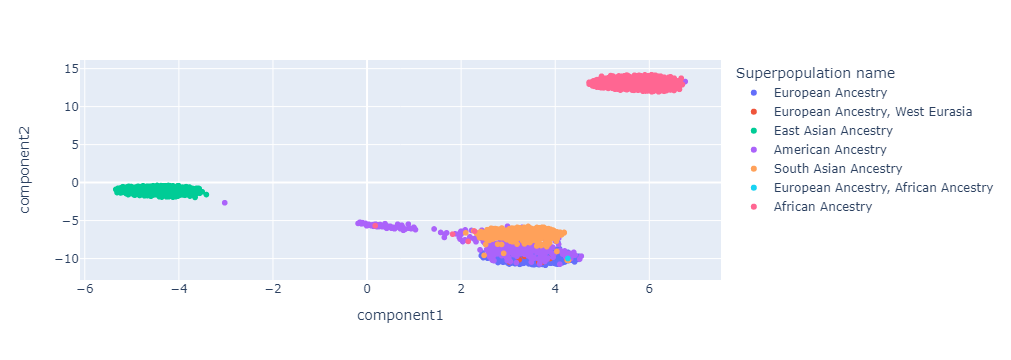

In [38]:
fig = px.scatter(umap_1000gens, x="component1", y="component2", color="Superpopulation name")
fig.show()

In [39]:
X = umap_1000gens.drop("Superpopulation name",  axis=1)
y = umap_1000gens["Superpopulation name"]
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
avg_acc = knn_eval(X=X, y=y)
dist_high, dist_low, corr, pval = spearman_correlation_eval(X=array, X_new=X.to_numpy())
trust = trustworthiness(array, X)
print(avg_acc)
print(trust)
print(f"Spearman correlation between pairwise distances: {corr}")
fig.write_image("umap_1000genomes_neighbor50.png")

0.9081405189620758
0.885003033607766
Spearman correlation between pairwise distances: 0.8019258046684995


## Visualization and Evaluation of AdaptMAP Project

### Incremental PCA

In [46]:
incpca = pd.read_csv("IncPCA_GPU_adaptmap.csv").set_index("iid")
incpca.head()

component1  component2     Breeds
iid                                          
ET_ABR0001   27.423950  -24.919245  Abergelle
ET_ABR0002   27.295452  -24.479732  Abergelle
ET_ABR0003   27.513855  -25.348494  Abergelle
ET_ABR0004   28.213834  -24.482369  Abergelle
ET_ABR0005   27.668138  -24.017340  Abergelle

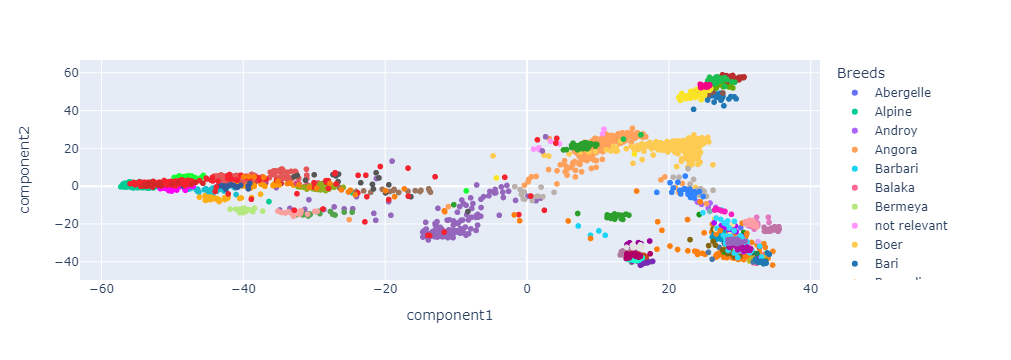

In [50]:
color_palette = px.colors.qualitative.Plotly
color_palette.extend(px.colors.qualitative.D3)
color_palette.extend(px.colors.qualitative.G10)
color_palette.extend(px.colors.qualitative.T10)
color_palette.extend(px.colors.qualitative.Alphabet)
fig = px.scatter(incpca, x="component1", y="component2", color="Breeds", color_discrete_sequence=color_palette)
fig.show()

In [54]:
array = np.load("Encoded Genotype Data.npy")
expl_var_ratio = PCA(n_components=2).fit(array).explained_variance_ratio_
print(f"variance explained by first component: {expl_var_ratio[0]}")
print(f"variance explained by second component: {expl_var_ratio[1]}")
print(f"Whole variance with 2 components: {expl_var_ratio.sum()}")

variance explained by first component: 0.02902897261083126
variance explained by second component: 0.020546816289424896
Whole variance with 2 components: 0.049575790762901306


In [65]:
"""X = incpca.drop("Breeds",  axis=1)
y = incpca["Breeds"]
print(X.dtypes)
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
#avg_acc = knn_eval(X=X, y=y)
dist_high, dist_low, corr, pval = spearman_correlation_eval(X=array, X_new=X.to_numpy())
#trust = trustworthiness(array, X)
print(avg_acc)
#print(trust)
print(f"Spearman correlation between pairwise distances: {corr}")"""
fig.write_image("incpca_adaptmap.png")

### t-SNE default

In [71]:
tsne = pd.read_csv("TSNE_GPU_adaptmap (1).csv").set_index("iid")
tsne.head()

component1  component2     Breeds
iid                                          
ET_ABR0001   42.045727   26.956886  Abergelle
ET_ABR0002   45.466545   23.352505  Abergelle
ET_ABR0003   39.130085   26.954721  Abergelle
ET_ABR0004   42.875393   26.871880  Abergelle
ET_ABR0005   38.830100   21.693975  Abergelle

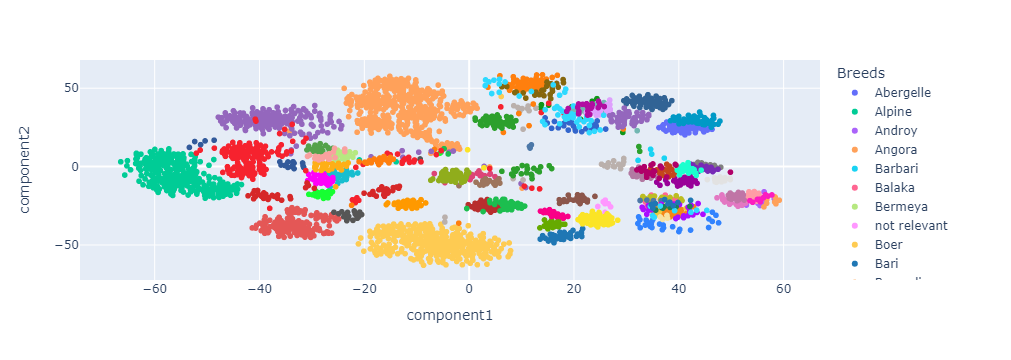

In [73]:
fig = px.scatter(tsne, x="component1", y="component2", color="Breeds", color_discrete_sequence=color_palette)
fig.show()

In [75]:
X = tsne.drop("Breeds",  axis=1)
y = tsne["Breeds"]
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
#avg_acc = knn_eval(X=X, y=y)
#dist_high, dist_low, corr, pval = spearman_correlation_eval(X=array, X_new=X.to_numpy())
#trust = trustworthiness(array, X)
#print(avg_acc)
#print(trust)
#print(f"Spearman correlation between pairwise distances: {corr}")
fig.write_image("tsne_adaptmap_default.png")

### tsne perplexity 10

In [77]:
tsne = pd.read_csv("TSNE_adaptmap_perp10.csv").set_index("iid")
tsne.head()

component1  component2     Breeds
iid                                          
ET_ABR0001  -48.532986   49.713333  Abergelle
ET_ABR0002  -50.957085   49.144250  Abergelle
ET_ABR0003  -42.179337   39.061314  Abergelle
ET_ABR0004  -43.920372   43.300430  Abergelle
ET_ABR0005  -41.688927   41.447490  Abergelle

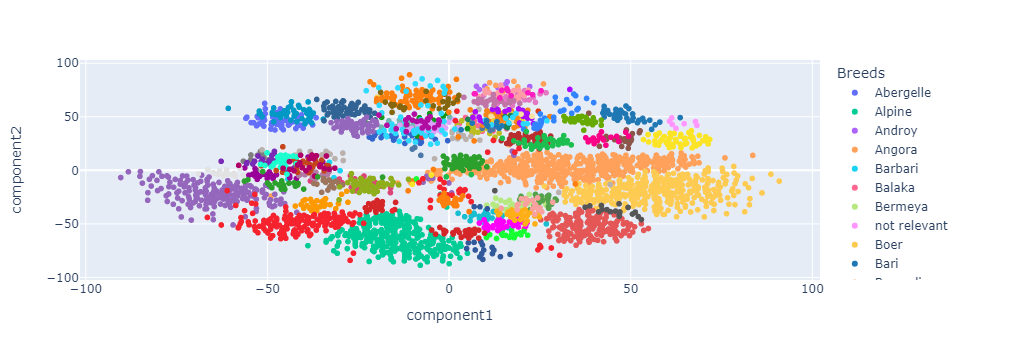

In [78]:
fig = px.scatter(tsne, x="component1", y="component2", color="Breeds", color_discrete_sequence=color_palette)
fig.show()

In [80]:
X = tsne.drop("Breeds",  axis=1)
y = tsne["Breeds"]
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
#avg_acc = knn_eval(X=X, y=y)
#dist_high, dist_low, corr, pval = spearman_correlation_eval(X=array, X_new=X.to_numpy())
#trust = trustworthiness(array, X)
#print(avg_acc)
#print(trust)
#print(f"Spearman correlation between pairwise distances: {corr}")
fig.write_image("tsne_adaptmap_perplexity10.png")

### tsne perplexity 50

In [81]:
tsne = pd.read_csv("TSNE_adaptmap_perp50.csv").set_index("iid")
tsne.head()

component1  component2     Breeds
iid                                          
ET_ABR0001   -9.310428  -21.252848  Abergelle
ET_ABR0002   -9.177458  -19.774212  Abergelle
ET_ABR0003  -10.593403  -20.075768  Abergelle
ET_ABR0004   -9.989574  -20.502367  Abergelle
ET_ABR0005   -6.908621  -19.770178  Abergelle

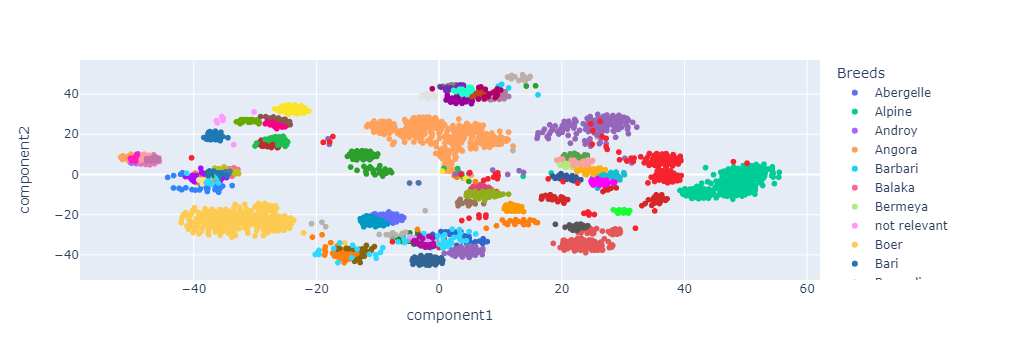

In [82]:
fig = px.scatter(tsne, x="component1", y="component2", color="Breeds", color_discrete_sequence=color_palette)
fig.show()

In [84]:
X = tsne.drop("Breeds",  axis=1)
y = tsne["Breeds"]
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
#avg_acc = knn_eval(X=X, y=y)
#dist_high, dist_low, corr, pval = spearman_correlation_eval(X=array, X_new=X.to_numpy())
#trust = trustworthiness(array, X)
#print(avg_acc)
#print(trust)
#print(f"Spearman correlation between pairwise dist
fig.write_image("tsne_adaptmap_perplexity50.png")

## UMAP default

In [14]:
umap = pd.read_csv("UMAP_adaptmap_default.csv").set_index("iid")
umap.head()

component1  component2     Breeds
iid                                          
ET_ABR0001    9.594469    5.937863  Abergelle
ET_ABR0002    9.591352    5.918972  Abergelle
ET_ABR0003    9.581578    5.948511  Abergelle
ET_ABR0004    9.567865    5.954383  Abergelle
ET_ABR0005    9.593259    5.920994  Abergelle

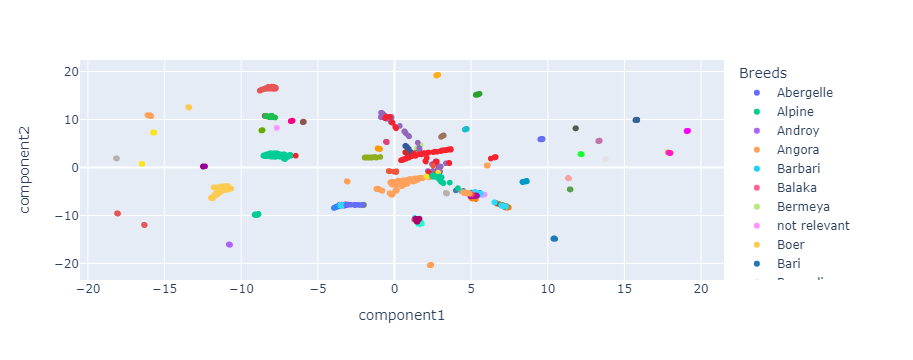

In [16]:
color_palette = px.colors.qualitative.Plotly
color_palette.extend(px.colors.qualitative.D3)
color_palette.extend(px.colors.qualitative.G10)
color_palette.extend(px.colors.qualitative.T10)
color_palette.extend(px.colors.qualitative.Alphabet)
fig = px.scatter(umap, x="component1", y="component2", color="Breeds", color_discrete_sequence=color_palette)
fig.show()

In [17]:
X = umap.drop("Breeds",  axis=1)
y = umap["Breeds"]
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
#avg_acc = knn_eval(X=X, y=y)
#dist_high, dist_low, corr, pval = spearman_correlation_eval(X=array, X_new=X.to_numpy())
#trust = trustworthiness(array, X)
#print(avg_acc)
#print(trust)
#print(f"Spearman correlation between pairwise dist
fig.write_image("umap_adaptmap_default.png")

### umap neighbors 5

In [19]:
umap = pd.read_csv("UMAP_adaptmap_neighbors5 (3).csv").set_index("iid")
umap.head()

component1  component2     Breeds
iid                                          
ET_ABR0001   -3.658320   14.610413  Abergelle
ET_ABR0002   -3.575765   14.516958  Abergelle
ET_ABR0003   -3.567728   14.538273  Abergelle
ET_ABR0004   -3.623781   14.537556  Abergelle
ET_ABR0005   -3.619000   14.589769  Abergelle

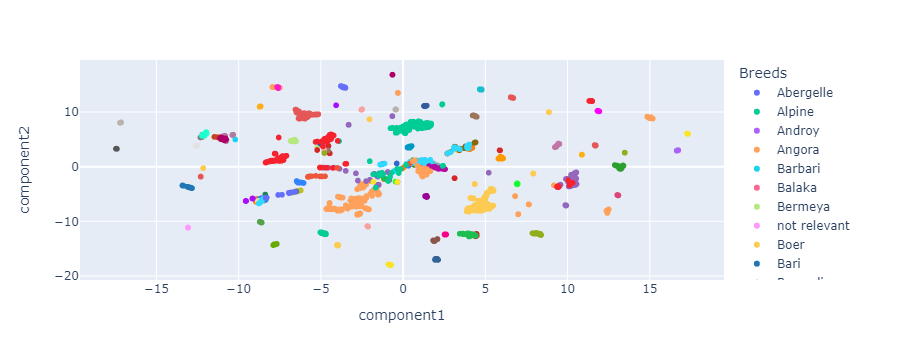

In [20]:
fig = px.scatter(umap, x="component1", y="component2", color="Breeds", color_discrete_sequence=color_palette)
fig.show()

In [21]:
X = umap.drop("Breeds",  axis=1)
y = umap["Breeds"]
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
#avg_acc = knn_eval(X=X, y=y)
#dist_high, dist_low, corr, pval = spearman_correlation_eval(X=array, X_new=X.to_numpy())
#trust = trustworthiness(array, X)
#print(avg_acc)
#print(trust)
#print(f"Spearman correlation between pairwise dist
fig.write_image("umap_adaptmap_neighbor5.png")

In [22]:
umap = pd.read_csv("UMAP_adaptmap_neighbors50 (1).csv").set_index("iid")
umap.head()

component1  component2     Breeds
iid                                          
ET_ABR0001   -5.290865    6.280587  Abergelle
ET_ABR0002   -5.218983    6.214294  Abergelle
ET_ABR0003   -5.269800    6.282075  Abergelle
ET_ABR0004   -5.222088    6.291340  Abergelle
ET_ABR0005   -5.289565    6.274065  Abergelle

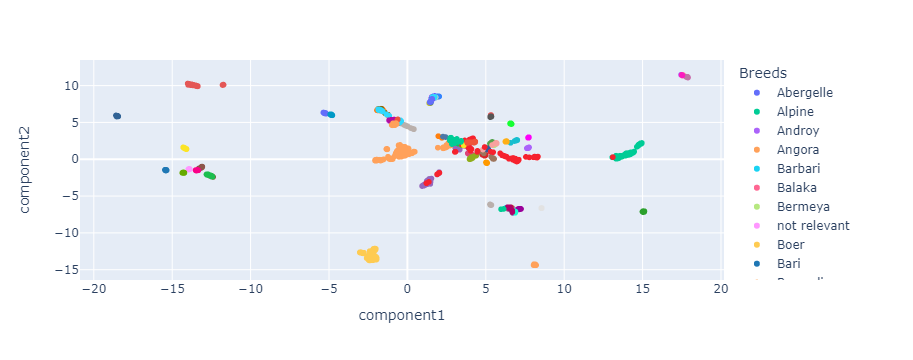

In [23]:
fig = px.scatter(umap, x="component1", y="component2", color="Breeds", color_discrete_sequence=color_palette)
fig.show()

In [24]:
X = umap.drop("Breeds",  axis=1)
y = umap["Breeds"]
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
#avg_acc = knn_eval(X=X, y=y)
#dist_high, dist_low, corr, pval = spearman_correlation_eval(X=array, X_new=X.to_numpy())
#trust = trustworthiness(array, X)
#print(avg_acc)
#print(trust)
#print(f"Spearman correlation between pairwise dist
fig.write_image("umap_adaptmap_neighbor50.png")

In [40]:
umap_red = pd.read_csv("UMAP_GPU_1000genomes.csv").set_index("Unnamed: 0")
umap_red2 = umap_red.rename(index={'Unnamed: 0': 'Sample'})
umap_red2.head()

component1  component2 Superpopulation name
Unnamed: 0                                             
HG00096      -0.315826    6.784998    European Ancestry
HG00097       0.126371    7.973272    European Ancestry
HG00099       0.411083    7.316635    European Ancestry
HG00100      -0.461454    8.295925    European Ancestry
HG00101      -0.857195    6.983219    European Ancestry

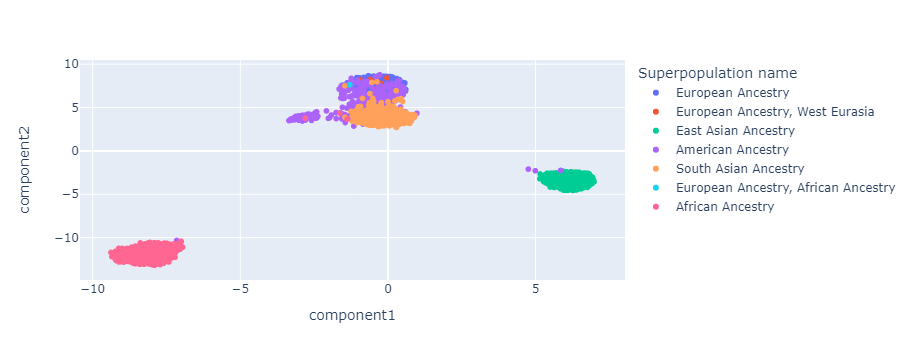

In [41]:
px.scatter(umap_red2, x="component1", y="component2", color="Superpopulation name")

In [42]:
umap_red = pd.read_csv("UMAP_GPU_adaptmap.csv").set_index("iid")
umap_red.head()

component1  component2     Breeds
iid                                          
ET_ABR0001  -14.081036   -0.519868  Abergelle
ET_ABR0002  -14.108814   -0.538992  Abergelle
ET_ABR0003  -14.070383   -0.557611  Abergelle
ET_ABR0004  -14.107050   -0.545480  Abergelle
ET_ABR0005  -14.121336   -0.549765  Abergelle

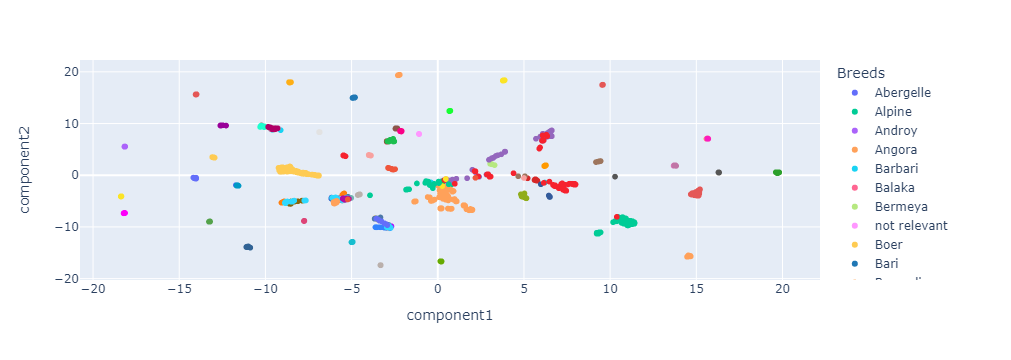

In [43]:
color_palette = px.colors.qualitative.Plotly
color_palette.extend(px.colors.qualitative.D3)
color_palette.extend(px.colors.qualitative.G10)
color_palette.extend(px.colors.qualitative.T10)
color_palette.extend(px.colors.qualitative.Alphabet)
fig = px.scatter(umap_red, x="component1", y="component2", color="Breeds", color_discrete_sequence=color_palette)
fig.show()

In [44]:
fig.write_image("test.png")

In [45]:
array = np.load("Encoded Genotype Data.npy")
array

array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]], dtype=float32)